In [1]:
import cv2
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%load_ext autoreload
%autoreload 2
from uhcsseg import io
from uhcsseg import hypercolumn, segment

Using Theano backend.


In [3]:
label_keys = {
    'background': -1,
    'matrix': 0,
    'network': 1,
    'spheroidite': 2,
    'widmanstatten': 3
}

label_map = {val: key for key, val in label_keys.items()} 

def segmentation_accuracy(prediction, groundtruth):
    return np.sum(prediction == groundtruth) / groundtruth.size

def segmentation_IU(prediction, groundtruth, cls):
    numerator = np.sum(np.logical_and((prediction == cls), (groundtruth == cls)))
    denominator = np.sum(np.logical_or((prediction == cls), (groundtruth == cls)))
    return numerator / denominator

def segmentation_avg_IU(prediction, groundtruth, classlist=None):
    if classlist is None:
        classlist = np.unique(np.concatenate((prediction, groundtruth)))
    avg_IU =  np.mean(list(
        segmentation_IU(prediction, groundtruth, cls) for cls in classlist
    ))
    return avg_IU

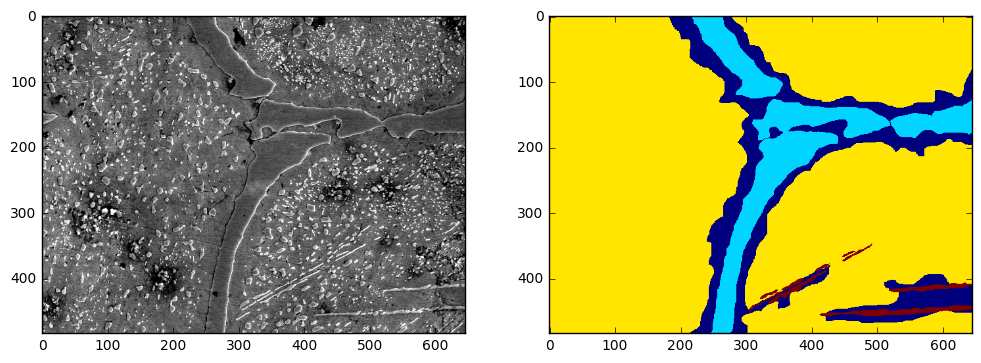

In [4]:
images, labels, keys = io.load_dataset('data/uhcs.h5', cropbar=38)
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(images[0], cmap=plt.cm.gray)
ax[1].imshow(labels[0])

In [5]:
hc = hypercolumn.ReducedHyperColumn()

ntrain = 20
Xtrain = hc.fit(images[:ntrain], verbose=True)

computing feature maps
reducing block1_conv2 features
interpolating block1_conv2 features
reducing block2_conv2 features
interpolating block2_conv2 features
reducing block3_conv3 features
interpolating block3_conv3 features
reducing block4_conv3 features
interpolating block4_conv3 features
reducing block5_conv3 features
interpolating block5_conv3 features


In [6]:
clf = segment.TensorSGD()
clf.fit(Xtrain, labels[:ntrain])

(6243600, 160)
SVM model finished.


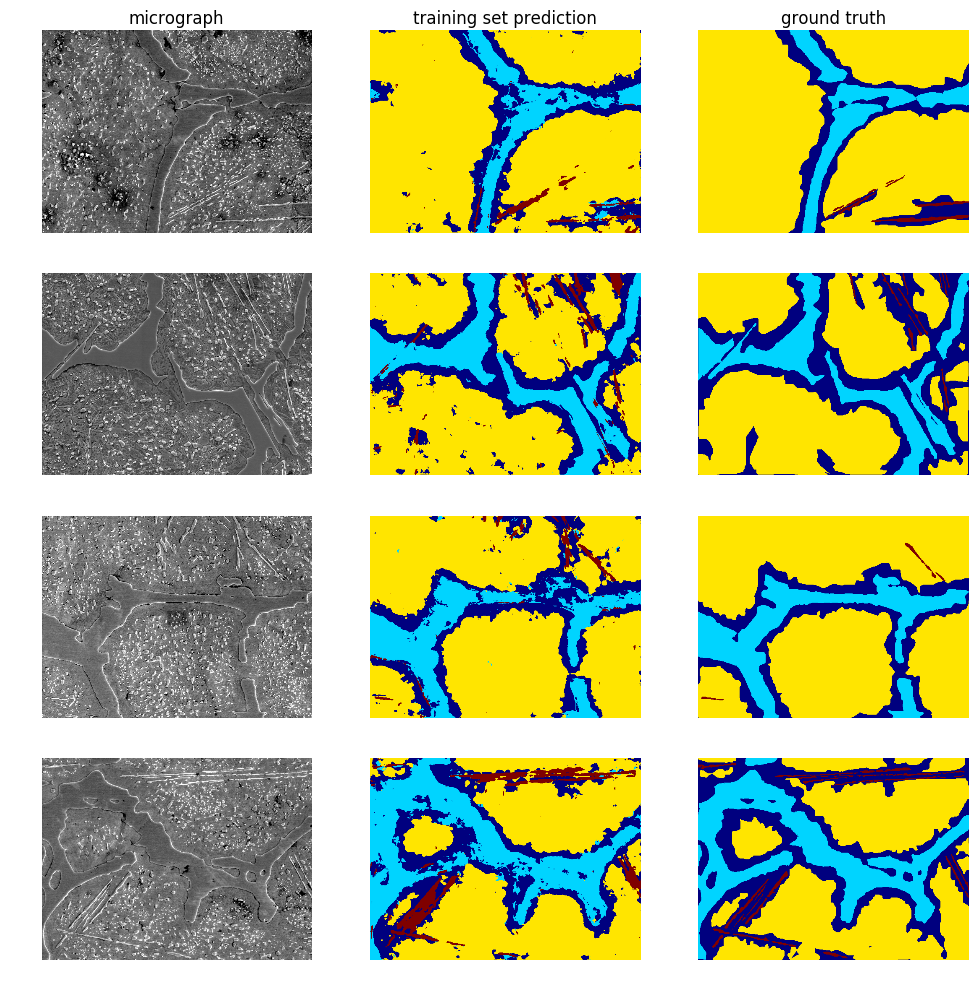

In [7]:
yy = clf.predict(Xtrain)
y = np.array(labels[:ntrain])

fig, axes = plt.subplots(4,3,figsize=(12,12))
idx = 0
for idx, ax in enumerate(axes):
    if idx == 0:
        for a, title in zip(ax, ('micrograph', 'training set prediction', 'ground truth')):
            a.set_title(title)
    ax[0].imshow(images[idx], cmap=plt.cm.gray)
    ax[1].imshow(yy[idx])
    ax[2].imshow(y[idx])
    
    for a in ax:
        a.axis('off')

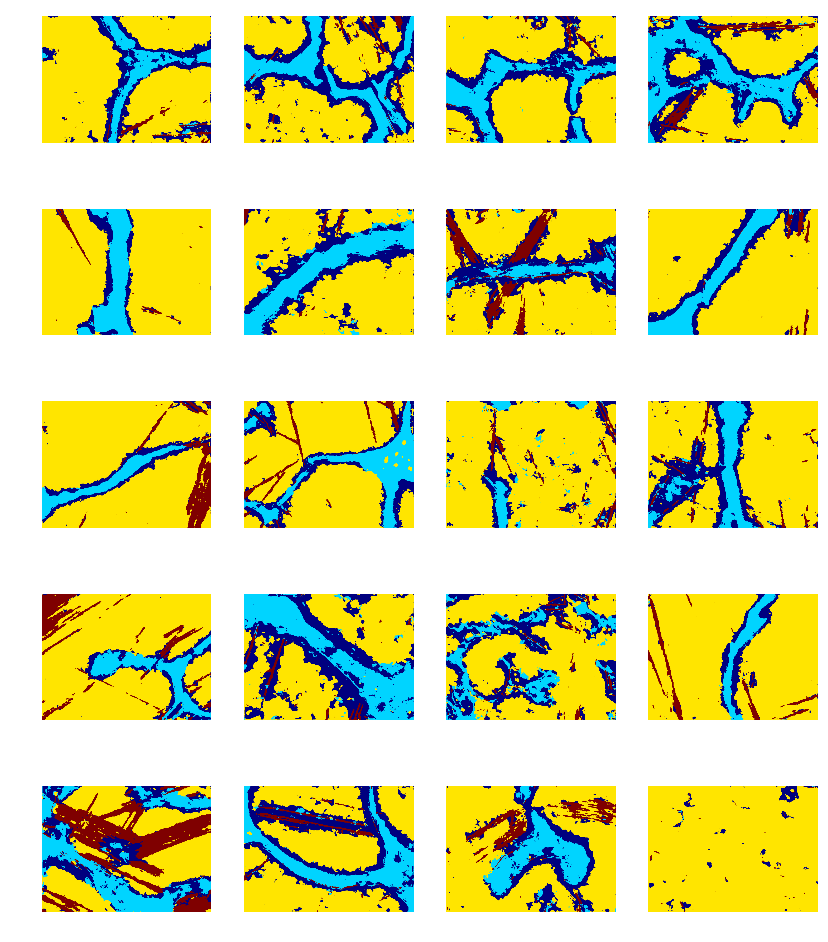

In [7]:
# display all training set predictions
fig, axes = plt.subplots(5,4, figsize=(10,12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(yy[idx])
    ax.axis('off')

In [10]:
# apply model to test images.... which don't have annotations yet.
test = [1232, 1356, 1411, 710]

from skimage.io import imread
def load_tif(m_id):
    im = imread('images/uhcs/micrograph{}.tif'.format(m_id), as_grey=True)
    return im[:-38]

# extract featuremaps for multiple images
# t_images = [load_tif(key) for key in test]

t_images = images[-4:]
t_labels = labels[-4:]
Xtest = hc.predict(t_images, verbose=True)

computing feature maps
reducing block1_conv2 features
interpolating block1_conv2 features
reducing block2_conv2 features
interpolating block2_conv2 features
reducing block3_conv3 features
interpolating block3_conv3 features
reducing block4_conv3 features
interpolating block4_conv3 features
reducing block5_conv3 features
interpolating block5_conv3 features


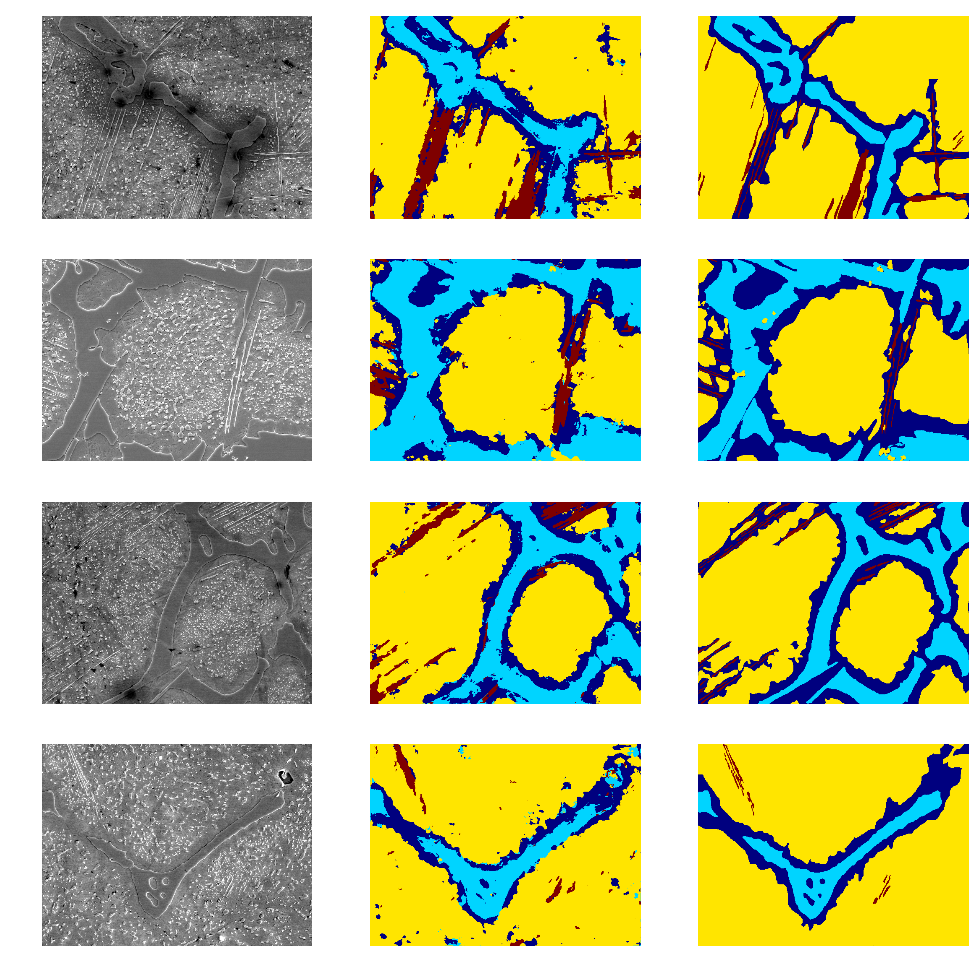

In [11]:
t_y = clf.predict(Xtest)

fig, axes = plt.subplots(4,3,figsize=(12,12))
idx = 0
for idx, ax in enumerate(axes):
    ax[0].imshow(t_images[idx], cmap=plt.cm.gray)
    ax[1].imshow(t_y[idx])
    ax[2].imshow(t_labels[idx])
    
    for a in ax:
        a.axis('off')

In [32]:
for pred, gt in zip(t_y, t_labels):
    print('ACC: ', end='')
    print(segmentation_accuracy(pred, gt))
    print('IU: ')
    for cls in range(4):
        print(label_map[cls], end=': \t')
        print(segmentation_IU(pred, gt, cls))
    print('avg IU: ', end='\t')
    print(segmentation_avg_IU(pred, gt))
    print('')

ACC: 0.843984239862
IU: 
matrix: 	0.408597167106
network: 	0.708244944138
spheroidite: 	0.869527726487
widmanstatten: 	0.45188104622
avg IU: 	0.609562720988

ACC: 0.839781536293
IU: 
matrix: 	0.520556020975
network: 	0.763124718595
spheroidite: 	0.864853092023
widmanstatten: 	0.328962559789
avg IU: 	0.619374097845

ACC: 0.859792427446
IU: 
matrix: 	0.516423811271
network: 	0.752976929708
spheroidite: 	0.896992164735
widmanstatten: 	0.396329757199
avg IU: 	0.640680665728

ACC: 0.910423473637
IU: 
matrix: 	0.509084936457
network: 	0.594143911551
spheroidite: 	0.939334190373
widmanstatten: 	0.336241883117
avg IU: 	0.594701230375



In [8]:
s_images, s_labels, s_keys = io.load_dataset('data/spheroidite.h5')
s_hc = hypercolumn.ReducedHyperColumn()

Xtrain = s_hc.fit(s_images[6:11], verbose=True)

computing feature maps
reducing block1_conv2 features
interpolating block1_conv2 features
reducing block2_conv2 features
interpolating block2_conv2 features
reducing block3_conv3 features
interpolating block3_conv3 features
reducing block4_conv3 features
interpolating block4_conv3 features
reducing block5_conv3 features
interpolating block5_conv3 features


In [9]:
s_labels = [(s > 0).astype(int) for s in s_labels]
s_clf = segment.TensorSGD()
s_clf.fit(Xtrain, s_labels[6:11])

(1531875, 160)
SVM model finished.


In [12]:
s_Xtest = s_hc.predict(t_images, verbose=True)

computing feature maps
reducing block1_conv2 features
interpolating block1_conv2 features
reducing block2_conv2 features
interpolating block2_conv2 features
reducing block3_conv3 features
interpolating block3_conv3 features
reducing block4_conv3 features
interpolating block4_conv3 features
reducing block5_conv3 features
interpolating block5_conv3 features


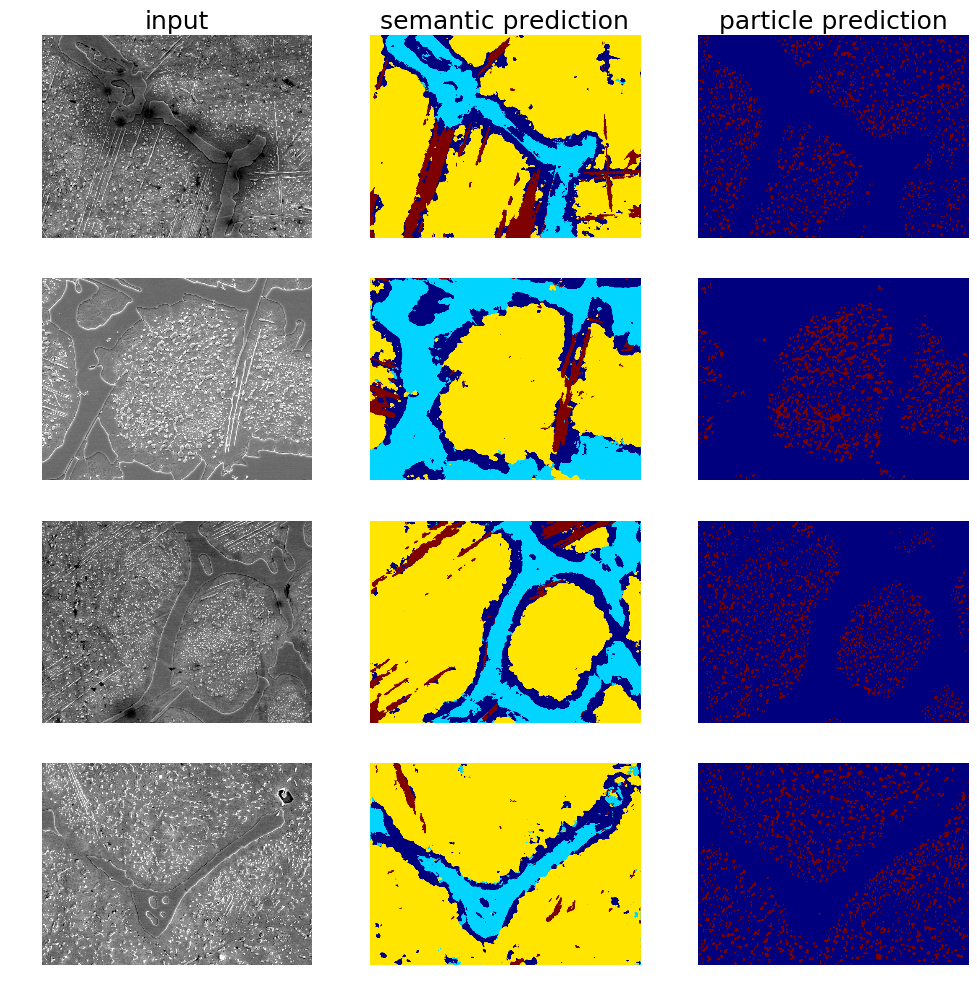

In [19]:
particle_pred = s_clf.predict(s_Xtest)
particle_pred[t_y != 2] = 0

fig, axes = plt.subplots(4,3,figsize=(12,12))
idx = 0
for idx, ax in enumerate(axes):
    if idx == 0:
        for a, title in zip(ax, ('input', 'semantic prediction', 'particle prediction')):
            a.set_title(title, size=18)
    ax[0].imshow(t_images[idx], cmap=plt.cm.gray)
    ax[1].imshow(t_y[idx])
    ax[2].imshow(particle_pred[idx])
    for a in ax:
        a.axis('off')
        
plt.savefig('chainedresults.pdf')

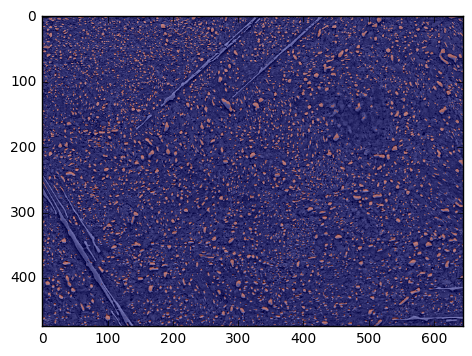

In [40]:
plt.imshow(s_images[7], cmap=plt.cm.gray)
plt.imshow(s_labels[7], alpha=0.5)

0.911510403917
0.896335354802
0.623249027237


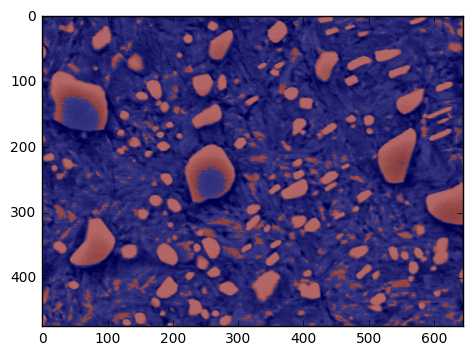

In [126]:
from skimage.filters import threshold_li, threshold_isodata, threshold_otsu, threshold_adaptive, threshold_yen

def segmentation_accuracy(prediction, groundtruth):
    return np.sum(prediction == groundtruth) / groundtruth.size

def segmentation_IU(prediction, groundtruth, cls):
    numerator = np.sum(np.logical_and((prediction == cls), (groundtruth == cls)))
    denominator = np.sum(np.logical_or((prediction == cls), (groundtruth == cls)))
    return numerator / denominator

# t = threshold_adaptive(s_images[0], block_size=5)
idx = 11
t = threshold_isodata(s_images[idx])
p = s_images[idx] > t

print(segmentation_accuracy(p, s_labels[idx]))
print(segmentation_IU(p, s_labels[idx], 0))
print(segmentation_IU(p, s_labels[idx], 1))

plt.imshow(s_images[idx], cmap=plt.cm.gray)
plt.imshow(p, alpha=0.6)

ACC:   0.890624235006
IU bg: 0.873034997784
IU fg: 0.558811912473


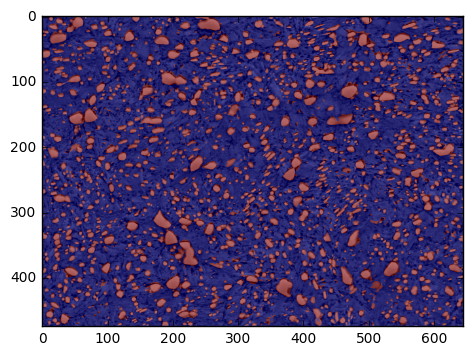

In [125]:
pred = s_clf.predict(Xtrain)
p = pred[4]

print('ACC:   ', end='')
print(segmentation_accuracy(p, s_labels[10]))
print('IU bg: ', end='')
print(segmentation_IU(p, s_labels[10], 0))
print('IU fg: ', end='')
print(segmentation_IU(p, s_labels[10], 1))

plt.imshow(s_images[10], cmap=plt.cm.gray)
# plt.imshow(s_labels[8], alpha=0.6)
plt.imshow(p, alpha=0.6)

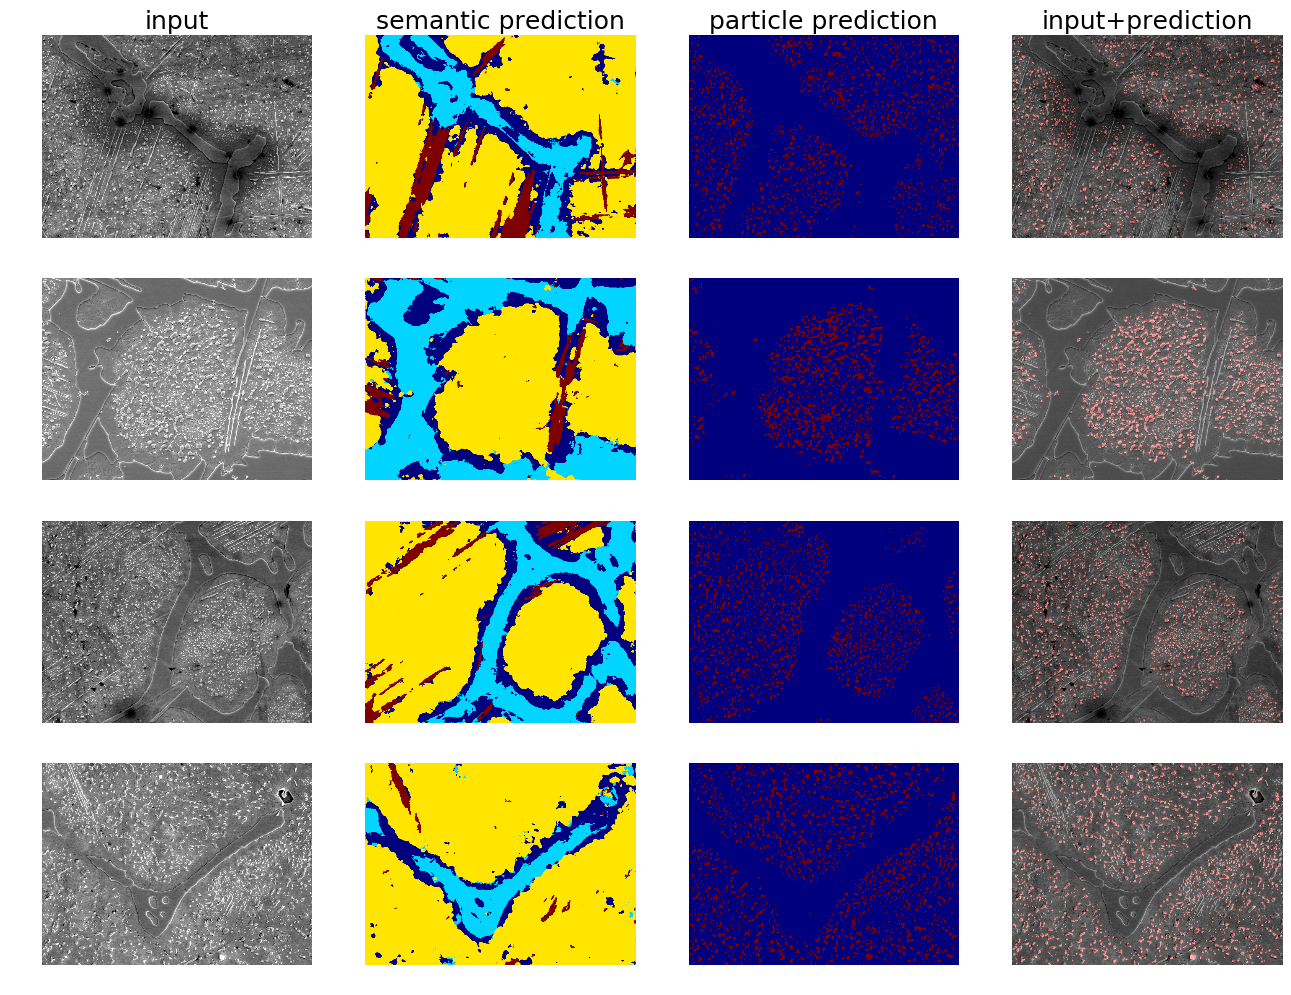

In [32]:
from skimage.color import label2rgb

particle_pred = s_clf.predict(s_Xtest)
particle_pred[t_y != 2] = 0

fig, axes = plt.subplots(4,4,figsize=(16,12))
idx = 0
for idx, ax in enumerate(axes):
    if idx == 0:
        for a, title in zip(ax, ('input', 'semantic prediction', 'particle prediction', 'input+prediction')):
            a.set_title(title, size=18)
    ax[0].imshow(t_images[idx], cmap=plt.cm.gray)
    ax[1].imshow(t_y[idx])
    ax[2].imshow(particle_pred[idx])
    ax[3].imshow(label2rgb(particle_pred[idx], image=t_images[idx], bg_label=0))

    for a in ax:
        a.axis('off')
        
# plt.savefig('chainedresults.pdf')

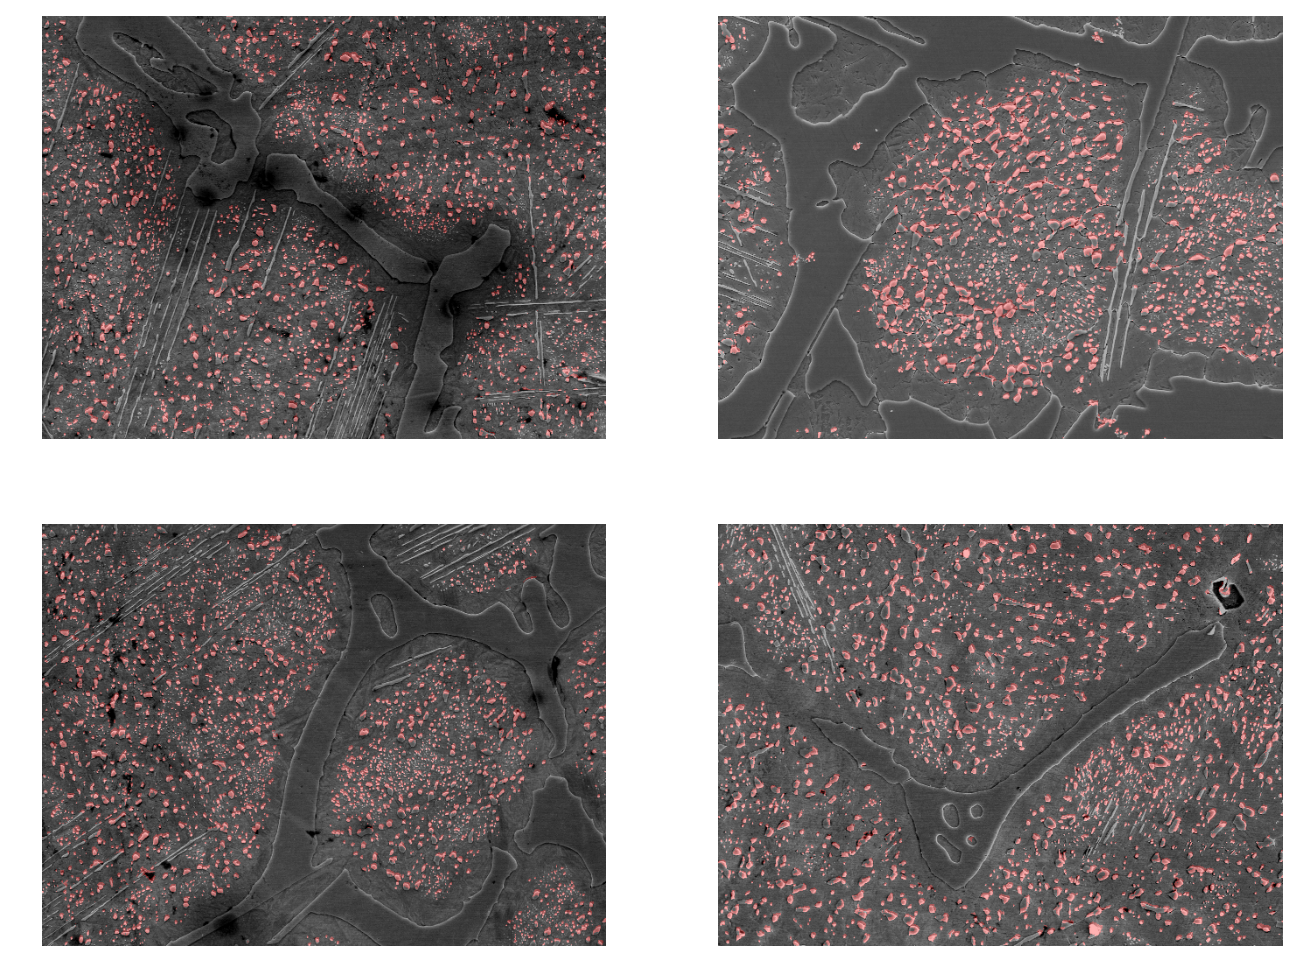

In [28]:
from skimage.color import label2rgb

particle_pred = s_clf.predict(s_Xtest)
particle_pred[t_y != 2] = 0

fig, axes = plt.subplots(2,2,figsize=(16,12))
idx = 0
for idx, ax in enumerate(axes.flatten()):

    ax.imshow(label2rgb(particle_pred[idx], image=t_images[idx], bg_label=0))
    # ax.imshow(t_images[idx], cmap=plt.cm.gray)
    # ax.imshow(particle_pred[idx], alpha = 0.5)
    ax.axis('off')